In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Define the path to the CSV file
data_path = os.path.join(os.getcwd(), 'preprocessed_data.csv')

# Load the dataset
df = pd.read_csv(data_path)

In [3]:
# Define your target column and feature columns
ycol = 'booking_earned'  # Replace 'target' with the actual name of your target column
xcol = ['stay_duration_in_days', 'booking_window', 'distance_to_coastline', 'lat', 
        'bedroom', 'review_sentiment_score', 'lng', 'beds', 'rating']



# Identify and remove categorical columns
# categorical_cols = df.select_dtypes(include=['object', 'category']).columns
# xcol = [col for col in df.columns if col != ycol and col not in categorical_cols]

In [4]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df[xcol], df[ycol], test_size=0.2, random_state=42)

In [5]:
# # this is for grid search
# # Define the parameter grid for GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

In [6]:
# Initialize the RandomForestRegressor
# rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42, bootstrap=False)


# Initialize GridSearchCV with cross-validation

#this is for grid search
# grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, 
#                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=2)

# # Fit the model with Grid Search
# grid_search.fit(x_train, y_train)

# # Get the best estimator
# best_rf_regressor = grid_search.best_estimator_

# Train the model
rf_regressor.fit(x_train, y_train)

# Predict on the test set
y_pred_train = rf_regressor.predict(x_train)
y_pred_test = rf_regressor.predict(x_test)

In [7]:
# Predict on the test set

# this is for grid search
# y_pred_train = best_rf_regressor.predict(x_train)
# y_pred_test = best_rf_regressor.predict(x_test)

y_pred_train = rf_regressor.predict(x_train)
y_pred_test = rf_regressor.predict(x_test)

In [8]:
from sklearn.metrics import mean_absolute_error

# Evaluate the model using MAE
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f'Training MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
#print(f'Best Parameters: {grid_search.best_params_}')

Training MAE: 19003.0769322941
Test MAE: 60621.265973749985


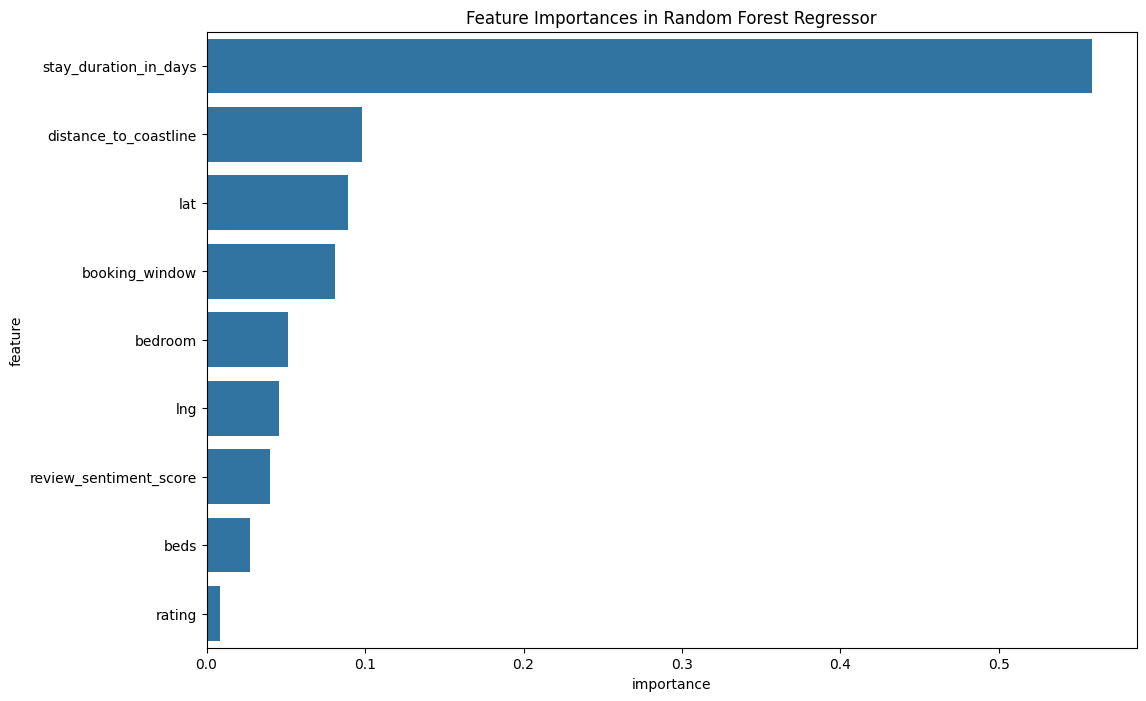

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importances = rf_regressor.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'feature': x_train.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df)
plt.title('Feature Importances in Random Forest Regressor')
plt.show()